<a href="https://colab.research.google.com/github/cbsobral/brazil-senate-agenda-analysis/blob/main/C%C3%B3pia_de_uncertainty_celeba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TODO:

MODEL
- ~implement augmentation on train~ DONE -- not great, accurary still ~50%
- ~test learning on 300 classes again (I think it was better?)~ DONE -- a bit better = 53%
- try other models
- save training metrics with the model (loss, acc)

UNCERTAINTY
- fix/understand dropout
- implement other methods (ensemble and tta)
  - distribution of uncertainty for all predictions
  - uncertainty for one sample of the dataset
  - transition from one sample to another and show distribution of preds



## Dataset Selection


The [CelebA (CelebFaces Attributes)](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset was selected after comparison with two alternatives: [Labeled Faces in the Wild](https://vis-www.cs.umass.edu/lfw/) and the [Yale Face](http://cvc.cs.yale.edu/cvc/projects/yalefaces/yalefaces.html) database. While Faces in the Wild lacks sufficient samples per identity class, and the Yale database has limited total samples despite good intra-class variation.

CelebA offers an extensive collection of over 200K images across 10,177 identities. Analysis of the identity distribution showed that over 2,000 classes have 30 or more samples. To balance computational efficiency with dataset quality, we filtered the dataset to the top 300 identities (~9,000 images).

This filtering ensures sufficient samples per class while keeping training time reasonable. Both versions maintain a minimum of 30 images per identity, providing enough variation for the model to learn robust features.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
from tqdm import tqdm
import timm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# Download dataset with 300 classes and ~9k samples
!gdown 1aRMM1cdvjXv8mke5Dd4hrgHNA3ZTkOc7 #
!unzip -q celeba_300.zip
!rm celeba_300.zip
dataset_dir = "celeba_300"


# Download dataset with 500 classes and ~15k samples
# !gdown 1Z6UMrQwje-D0VvcKPEXUHzuBvWzCMyAh # -- 500 classes
# !unzip -q celeba_500.zip
# !rm celeba_500.zip
# dataset_dir = "celeba_500"

Downloading...
From (original): https://drive.google.com/uc?id=1aRMM1cdvjXv8mke5Dd4hrgHNA3ZTkOc7
From (redirected): https://drive.google.com/uc?id=1aRMM1cdvjXv8mke5Dd4hrgHNA3ZTkOc7&confirm=t&uuid=b63988cb-0c6c-4a36-81e8-647b5c4d5bd7
To: /content/celeba_300.zip
100% 66.0M/66.0M [00:02<00:00, 27.1MB/s]


## Dataset

`CelebADataset` is the custom dataset class that handles the images. The class implements two different transform pipelines: a basic one for testing and an augmented one for training. The training transforms increase dataset variety by:

- Randomly flipping images horizontally
- Slightly rotating, shifting, and scaling images
- Adjusting image brightness, contrast, and saturation
- Adding blur and noise
- randomly erasing small image patches

The data loader function `create_data_loaders` splits the dataset into training and testing sets, ensuring each uses the appropriate transforms.

In [2]:
# @title Dataset and Loader

class CelebADataset(Dataset):
    def __init__(self, root_dir=dataset_dir, train=True):
        # Load metadata
        info = torch.load(os.path.join(root_dir, "dataset_info.pt"))
        self.metadata = info["metadata"]
        self.n_classes = info["n_classes"]
        self.root_dir = root_dir
        self.train = train

        # Basic transform for testing
        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),                    # Resize image to standard input size
            transforms.ToTensor(),
            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],   # Normalize using ImageNet stats -- MobileNet trained on ImageNet
                                std=[0.229, 0.224, 0.225])
        ])

        # Augmented transform for training
        self.train_transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.RandomHorizontalFlip(p=0.5),     # Flip horizontally 50% of time
          transforms.RandomAffine(                    # Stronger geometric transforms
              degrees=(-10, 10),                      # Rotate ±10°
              translate=(0.1, 0.1),                   # Shift up to 10% any direction
              scale=(0.85, 1.15),                     # Scale 85-115% of original
              fill=255                                # Fill edges white
          ),
          transforms.RandomPerspective(               # Perspective warping
              distortion_scale=0.2,                   # Moderate distortion
              p=0.5                                   # 50% chance to apply
          ),
          transforms.ColorJitter(                     # Enhanced color augmentation
              brightness=0.3,                         # ±30% brightness variation
              contrast=0.3,                           # ±30% contrast variation
              saturation=0.2,                         # ±20% saturation variation
          ),
          transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),  # Slight blur
          transforms.ToTensor(),                      # Convert to tensor
          transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.02),  # 2% noise
          transforms.RandomErasing(                   # Random patch removal
              p=0.2,                                  # 20% chance to erase
              scale=(0.02, 0.15)                      # Erase 2-15% of image
          ),
          transforms.Normalize(                       # ImageNet normalization
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]
          )
        ])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_data = self.metadata[idx]
        img_path = os.path.join(self.root_dir, "images", img_data["img_name"])

        # Load image
        image = Image.open(img_path)

        # Apply appropriate transform
        if self.train:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)

        return image, img_data["identity"]


def create_data_loaders(batch_size=32, train_split=0.8):
    # Create full dataset
    full_dataset = CelebADataset()

    # Calculate splits
    train_size = int(train_split * len(full_dataset))
    test_size = len(full_dataset) - train_size

    # Create splits
    train_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Modify datasets to have correct transforms
    train_dataset.dataset.train = True
    test_dataset.dataset.train = False

    # Create loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    return train_loader, test_loader, full_dataset.n_classes

## Model Architecture and Training

The `FaceClassifier` class wraps a pretrained MobileNetV3 model, adapting it for face recognition with an added dropout layer for uncertainty estimation.

Training uses standard deep learning practices:

- Cross-entropy loss for classification
- AdamW optimizer for parameter updates
- Learning rate scheduling to reduce learning rate when performance plateaus
- Model checkpointing to save the best performing version

The training loop monitors both training and testing performance, saving the model whenever it achieves better accuracy on the test set.


In [16]:
# @title Model Architecture and Setup

# FIXME: hide warning message

class FaceClassifier(nn.Module):
    def __init__(self, model_name, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes, drop_rate=dropout_rate)
        self.dropout_rate = dropout_rate

    def enable_dropout(self):
        # For MC dropout at inference
        self.train()
        self.model.head_drop.train()  # Keep dropout active even in eval mode

    def forward(self, x):
        return self.model(x)


# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    return running_loss / len(train_loader), accuracy

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    return running_loss / len(test_loader), accuracy

train_loader, test_loader, num_classes = create_data_loaders(batch_size=32)

Training samples: 7230
Testing samples: 1808



The selected models have complementary architectures. Inception-ResNet v2 as main model with built-in dropout for uncertainty. MobileNetV3 and EfficientNet-B4 have no dropout layers and provide ensemble uncertainty through their different architectures.

In [20]:
# @title Training Loop
import time
import copy

# model_names = ['inception_resnet_v2', 'efficientnet_b4', 'mobilenetv3_large_100']
model_names = ['mobilenetv3_large_100'] # For testing, much faster than the rest
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 10
patience = 3  # Early stopping patience

metrics = {model_name: {
   'epochs': [],
   'train_loss': [],
   'train_acc': [],
   'test_loss': [],
   'test_acc': []
} for model_name in model_names}

for model_name in model_names:
    start_time = time.time()
    print(f"\nTraining {model_name}\n")

    model = FaceClassifier(model_name, num_classes, dropout_rate=0.5).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    best_accuracy = 0.0
    min_valid_loss = float('inf')
    no_improve_count = 0
    best_state_dict = None

    metrics[model_name] = {
        'epochs': [], 'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}: \n")

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        # Update metrics
        for key, value in zip(metrics[model_name].keys(), [epoch, train_loss, train_acc, test_loss, test_acc]):
            metrics[model_name][key].append(value)

        # Track best model
        if test_acc > best_accuracy:
            print(f"\nNew best accuracy! ({test_acc:.2f}% > {best_accuracy:.2f}%)")
            best_accuracy = test_acc
            best_state_dict = copy.deepcopy(model.state_dict())

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        print("-" * 50 + "\n")

        # Early stopping
        if test_loss < min_valid_loss:
            min_valid_loss = test_loss
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    training_time = time.time() - start_time
    hours = int(training_time // 3600)
    minutes = int((training_time % 3600) // 60)
    seconds = int(training_time % 60)
    print(f"Total training time for {model_name}: {hours}h {minutes}m {seconds}s")

    # Save best model at end
    if os.path.exists(f'best_{model_name}_model.pt'):
        os.remove(f'best_{model_name}_model.pt')
        time.sleep(12)

    torch.save({
        'model_state_dict': best_state_dict,
        'metrics': metrics[model_name],
    }, f'best_{model_name}_model.pt')
    print("\nBest model saved successfully.")


Training mobilenetv3_large_100

Epoch 1/10: 



Evaluating: 100%|██████████| 57/57 [00:05<00:00,  9.79it/s]



New best accuracy! (24.45% > 0.00%)
Train Loss: 4.9047, Train Acc: 9.72%
Test Loss: 3.8447, Test Acc: 24.45%
--------------------------------------------------

Epoch 2/10: 



Evaluating: 100%|██████████| 57/57 [00:04<00:00, 12.50it/s]



New best accuracy! (47.12% > 24.45%)
Train Loss: 3.0817, Train Acc: 43.08%
Test Loss: 2.9417, Test Acc: 47.12%
--------------------------------------------------

Epoch 3/10: 



Evaluating: 100%|██████████| 57/57 [00:05<00:00, 10.06it/s]



New best accuracy! (59.73% > 47.12%)
Train Loss: 2.0485, Train Acc: 71.34%
Test Loss: 2.5084, Test Acc: 59.73%
--------------------------------------------------

Epoch 4/10: 



Evaluating: 100%|██████████| 57/57 [00:04<00:00, 12.84it/s]



New best accuracy! (64.05% > 59.73%)
Train Loss: 1.5166, Train Acc: 89.23%
Test Loss: 2.3123, Test Acc: 64.05%
--------------------------------------------------

Epoch 5/10: 



Evaluating: 100%|██████████| 57/57 [00:04<00:00, 12.78it/s]



New best accuracy! (71.35% > 64.05%)
Train Loss: 1.2823, Train Acc: 96.80%
Test Loss: 2.1145, Test Acc: 71.35%
--------------------------------------------------

Epoch 6/10: 



Evaluating: 100%|██████████| 57/57 [00:05<00:00,  9.89it/s]



New best accuracy! (71.90% > 71.35%)
Train Loss: 1.1832, Train Acc: 98.99%
Test Loss: 2.0793, Test Acc: 71.90%
--------------------------------------------------

Epoch 7/10: 



Evaluating: 100%|██████████| 57/57 [00:04<00:00, 12.60it/s]



New best accuracy! (73.06% > 71.90%)
Train Loss: 1.1463, Train Acc: 99.45%
Test Loss: 2.0555, Test Acc: 73.06%
--------------------------------------------------

Epoch 8/10: 



Evaluating: 100%|██████████| 57/57 [00:06<00:00,  9.16it/s]


Train Loss: 1.1206, Train Acc: 99.76%
Test Loss: 2.0763, Test Acc: 71.68%
--------------------------------------------------

Epoch 9/10: 



Evaluating: 100%|██████████| 57/57 [00:04<00:00, 12.75it/s]


Train Loss: 1.1084, Train Acc: 99.68%
Test Loss: 2.0911, Test Acc: 72.84%
--------------------------------------------------

Epoch 10/10: 



Evaluating: 100%|██████████| 57/57 [00:04<00:00, 11.88it/s]


Train Loss: 1.1040, Train Acc: 99.76%
Test Loss: 2.1008, Test Acc: 72.18%
--------------------------------------------------

Early stopping triggered after 10 epochs
Total training time for mobilenetv3_large_100: 0h 5m 26s


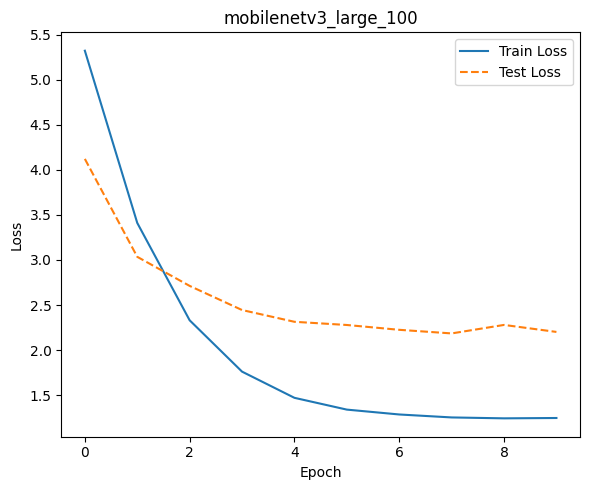

In [21]:
import matplotlib.pyplot as plt

# Plot metrics
def plot_metrics(metrics, model_names):
    fig, axes = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))

    # Handle both single and multiple subplots
    axes = [axes] if len(model_names) == 1 else axes

    for i, model_name in enumerate(model_names):
        axes[i].plot(metrics[model_name]['train_loss'], label='Train Loss')
        axes[i].plot(metrics[model_name]['test_loss'], '--', label='Test Loss')
        axes[i].set_title(model_name)
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_metrics(metrics, model_names)

In [ ]:
# @title Load Models (NOT IMPLEMENTED)

# FIXME: Add drive links
# Download inception_resnet_v2
!gdown # LINK

# Download efficientnet_b4
!gdown # LINK

# Download mobilenetv3_large_100
!gdown # LINK


def load_saved_model(model_name, model_path, num_classes=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FaceClassifier(model_name, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    print(f"Model '{model_name}' loaded successfully from {model_path}.")
    return model, device

# Paths to saved models
model_names = ['inception_resnet_v2', 'efficientnet_b4', 'mobilenetv3_large_100']  # Already defined above, here only for clarity
saved_model_paths = {
    "inception_resnet_v2": "best_inception_resnet_v2_model.pt",
    "densenet201": "best_densenet201_model.pt",
    "resnet152": "best_resnet152_model.pt"
}

# Load models
loaded_models = {}

for model_name in model_names:
    model_path = saved_model_paths.get(model_name)
    if not model_path or not os.path.exists(model_path):
        print(f"Warning: Model file for '{model_name}' not found. Skipping...")
        continue

    # Load model
    model, device = load_saved_model(model_name, model_path)
    loaded_models[model_name] = model

## Uncertainty

In [7]:
# @title Dropout